# Brandon Francisco Flores


## 1 Transformada de Fourier
### 1.


Mounted at /content/drive


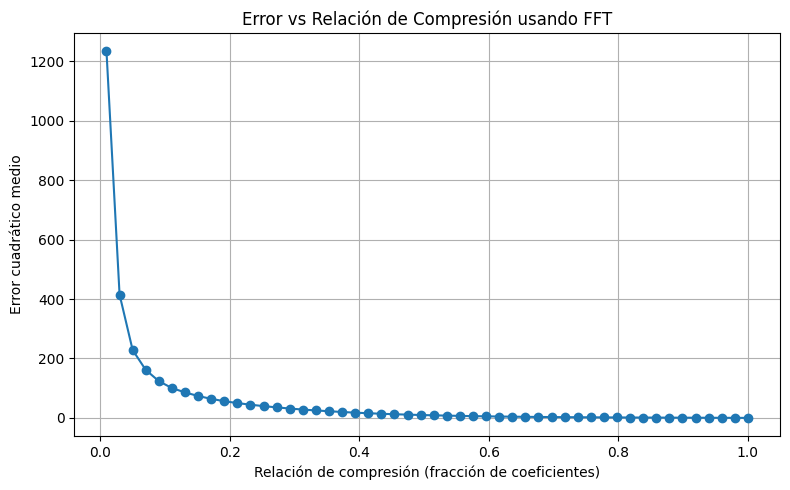

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')


def load_image(path):
    """
    Carga una imagen y la convierte a escala de grises.
    """
    img = Image.open(path).convert('L')
    return np.array(img)


def compress_fft(img, keep_fraction):
    """
    Comprime una imagen usando FFT.

    """
    # Transformada de Fourier
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    # Construir máscara central
    h, w = img.shape
    crow, ccol = h // 2, w // 2
    mask = np.zeros_like(img, dtype=bool)

    # Definir tamaño de la ventana central
    r_h = int(crow * keep_fraction)
    r_w = int(ccol * keep_fraction)
    mask[crow - r_h:crow + r_h, ccol - r_w:ccol + r_w] = True

    # Aplicar máscara y reconstruir
    fshift_compressed = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_compressed)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    return img_back


def compute_mse(orig, recon):
    """
    Calcula el error cuadrático medio entre dos imágenes.
    """
    return np.mean((orig - recon) ** 2)


def main():
    # Cargar imagen en escala de grises
    img = load_image('/content/drive/MyDrive/dog.jpg')

    # Definir relaciones de compresión (fracción de coeficientes)
    ratios = np.linspace(0.01, 1.0, 50)
    errors = []

    # Comprimir con diferentes ratios y calcular error
    for r in ratios:
        recon = compress_fft(img, r)
        mse = compute_mse(img, recon)
        errors.append(mse)

    # Graficar error vs relación de compresión
    plt.figure(figsize=(8, 5))
    plt.plot(ratios, errors, marker='o')
    plt.xlabel('Relación de compresión (fracción de coeficientes)')
    plt.ylabel('Error cuadrático medio')
    plt.title('Error vs Relación de Compresión usando FFT')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()


### 2.

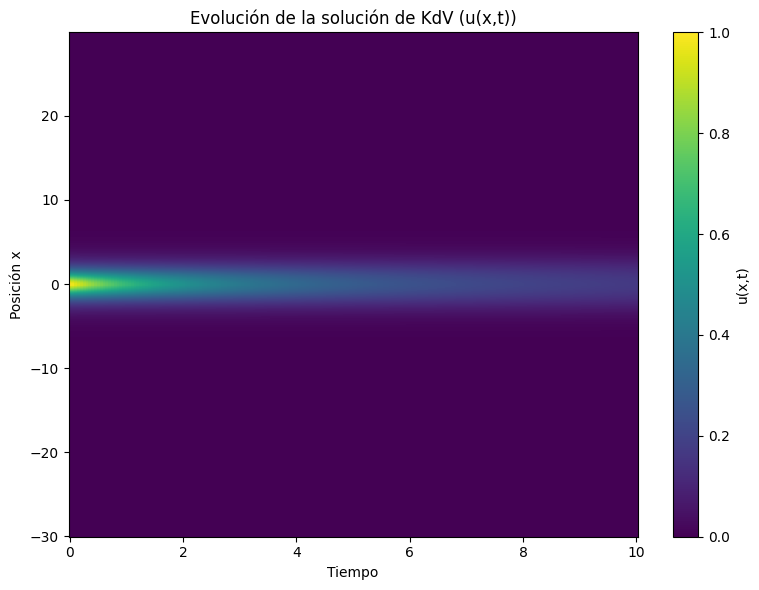

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Ecuación de KdV: u_t + u_{xxx} - u u_x = 0

def kdv_solver(N=512, L=60.0, dt=0.01, tmax=5.0, nplots=100):
    """
    Resuelve la ecuación de KdV usando método espectral y RK4.
    """
    # Discretización espacial
    dx = L / N
    x = np.linspace(-L/2, L/2 - dx, N)

    # Vector de frecuencias para derivadas espectrales
    k = (2*np.pi/L) * np.fft.fftfreq(N)
    ik = 1j * k
    ik3 = (1j * k)**3

    # Condición inicial u(x,0) = sech(x)
    u0 = 1.0 / np.cosh(x)
    u_hat = np.fft.fft(u0)

    # Número de pasos y almacenamiento
    nsteps = int(np.ceil(tmax/dt))
    plot_every = max(1, nsteps // nplots)
    ts = []
    usol = []

    # Operador lineal en Fourier
    def L_hat(u_hat):
        return -ik3 * u_hat

    # No lineal en espacio
    def N_hat(u):
        u_x = np.fft.ifft(ik * np.fft.fft(u)).real
        return -0.5 * np.fft.fft(u**2)

    # RK4 en Fourier
    u_hat_current = u_hat.copy()
    t = 0.0
    for step in range(nsteps+1):
        if step % plot_every == 0:
            u = np.fft.ifft(u_hat_current).real
            ts.append(t)
            usol.append(u)

        # RK4
        # k1
        u = np.fft.ifft(u_hat_current).real
        k1 = L_hat(u_hat_current) + N_hat(u)
        # k2
        u_hat2 = u_hat_current + 0.5*dt*k1
        u2 = np.fft.ifft(u_hat2).real
        k2 = L_hat(u_hat2) + N_hat(u2)
        # k3
        u_hat3 = u_hat_current + 0.5*dt*k2
        u3 = np.fft.ifft(u_hat3).real
        k3 = L_hat(u_hat3) + N_hat(u3)
        # k4
        u_hat4 = u_hat_current + dt*k3
        u4 = np.fft.ifft(u_hat4).real
        k4 = L_hat(u_hat4) + N_hat(u4)

        # Actualizar
        u_hat_current += (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        t += dt

    return x, np.array(ts), np.array(usol)


def main():
    x, ts, usol = kdv_solver(N=512, L=60.0, dt=0.005, tmax=10.0, nplots=200)

    # Graficar evolución como un mapa de color (x vs t)
    T, X = np.meshgrid(ts, x)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(ts, x, usol.T, shading='auto')
    plt.xlabel('Tiempo')
    plt.ylabel('Posición x')
    plt.title('Evolución de la solución de KdV (u(x,t))')
    plt.colorbar(label='u(x,t)')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


## 2 Sparsity and Compressed Sensing
### 1.

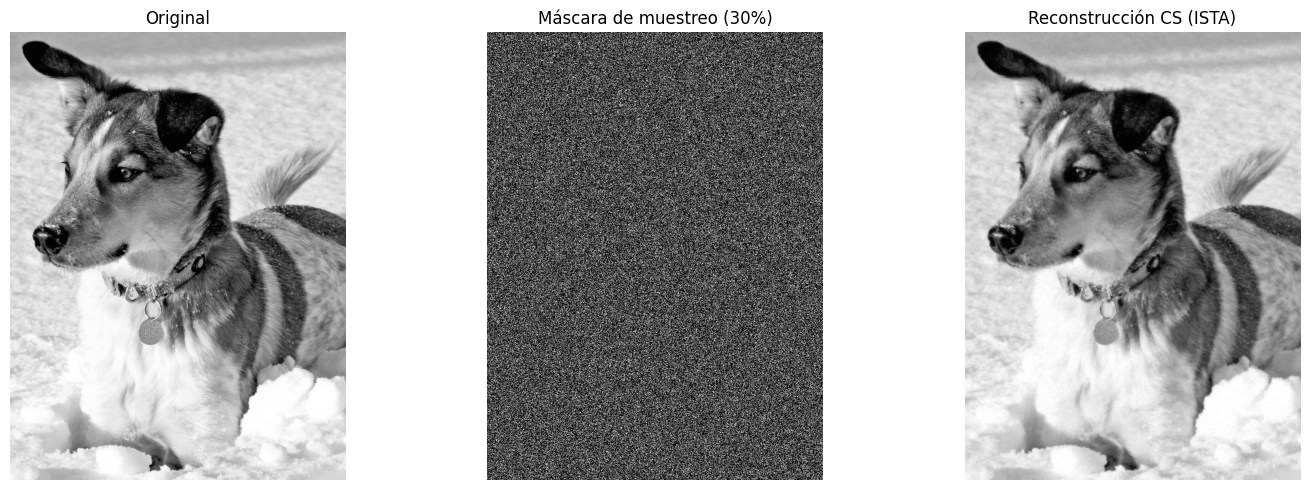

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import dct, idct

# Funciones auxiliares para DCT2 e IDCT2
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

# Función de umbral suave (soft-thresholding)
def soft_threshold(X, threshold):
    return np.sign(X) * np.maximum(np.abs(X) - threshold, 0)

# Cargar imagen y convertir a escala de grises normalizada [0,1]
def load_image(path):
    img = Image.open(path).convert('L')
    return np.array(img, dtype=float) / 255.0

# Crear máscara de muestreo aleatorio binaria
def create_mask(shape, fraction, seed=None):
    if seed is not None:
        np.random.seed(seed)
    total = shape[0] * shape[1]
    mask = np.zeros(total, dtype=bool)
    mask[np.random.choice(total, int(fraction * total), replace=False)] = True
    return mask.reshape(shape)

# Reconstrucción vía ISTA en dominio DCT (Compressed Sensing)
def reconstruct_cs_ista(y, mask, n_iter=200, lam=0.01, alpha=1.0):
    # x inicia con ceros y mantenimiento de mediciones
    x = np.zeros_like(y)
    x[mask] = y[mask]

    for i in range(n_iter):
        # Paso de gradiente en imagen: grad = mask * (y - x)
        grad = mask * (y - x)
        x_temp = x + alpha * grad

        # Umbral en dominio DCT
        X = dct2(x_temp)
        X_thresh = soft_threshold(X, lam)
        x = idct2(X_thresh)

        # Reimponer mediciones conocidas
        x[mask] = y[mask]

    return np.clip(x, 0, 1)

# Script principal
def main():
    # Parámetros
    sampling_fraction = 0.30  # porcentaje de píxeles medidos
    n_iter = 300             # iteraciones ISTA
    lam = 0.02               # parámetro de regularización l1
    alpha = 1.0             # tamaño de paso gradient descent

    # Cargar imagen
    img = load_image('/content/drive/MyDrive/dog.jpg')

    # Generar máscara y mediciones
    mask = create_mask(img.shape, sampling_fraction, seed=42)
    y = np.zeros_like(img)
    y[mask] = img[mask]

    # Reconstrucción CS vía ISTA
    recon = reconstruct_cs_ista(y, mask, n_iter=n_iter, lam=lam, alpha=alpha)

    # Visualizar resultados
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Máscara de muestreo (30%)')
    axes[1].axis('off')

    axes[2].imshow(recon, cmap='gray')
    axes[2].set_title('Reconstrucción CS (ISTA)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

### 2.


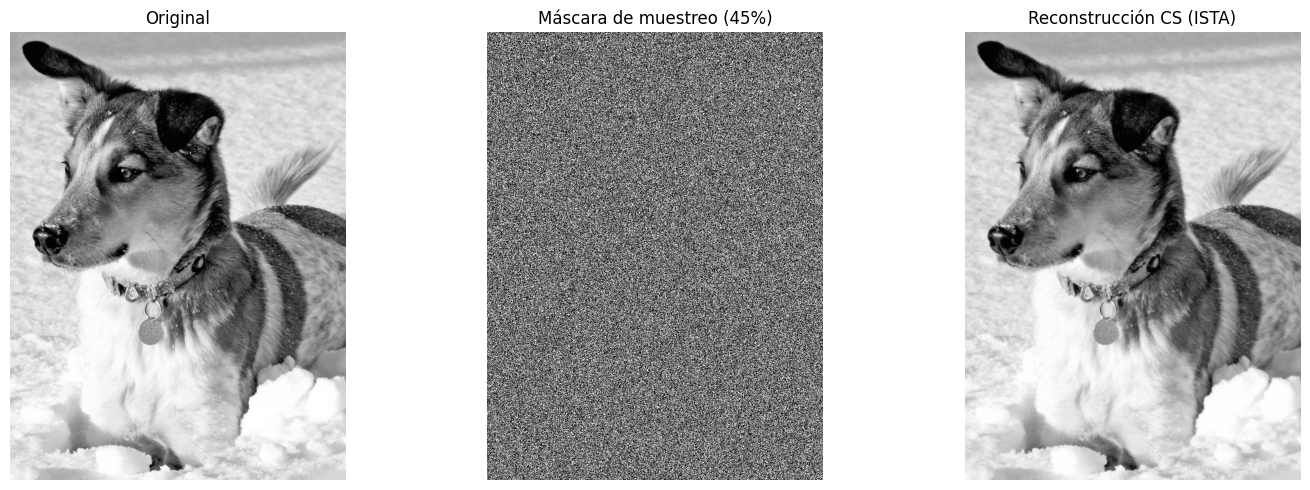

In [10]:
# Script principal
def main():
    # Parámetros
    sampling_fraction = 0.45
    n_iter = 300
    lam = 0.02
    alpha = 1.0

    # Cargar imagen
    img = load_image('/content/drive/MyDrive/dog.jpg')

    # Generar máscara y mediciones
    mask = create_mask(img.shape, sampling_fraction, seed=42)
    y = np.zeros_like(img)
    y[mask] = img[mask]

    # Reconstrucción CS vía ISTA
    recon = reconstruct_cs_ista(y, mask, n_iter=n_iter, lam=lam, alpha=alpha)

    # Visualizar resultados
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Máscara de muestreo (45%)')
    axes[1].axis('off')

    axes[2].imshow(recon, cmap='gray')
    axes[2].set_title('Reconstrucción CS (ISTA)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

### 3.


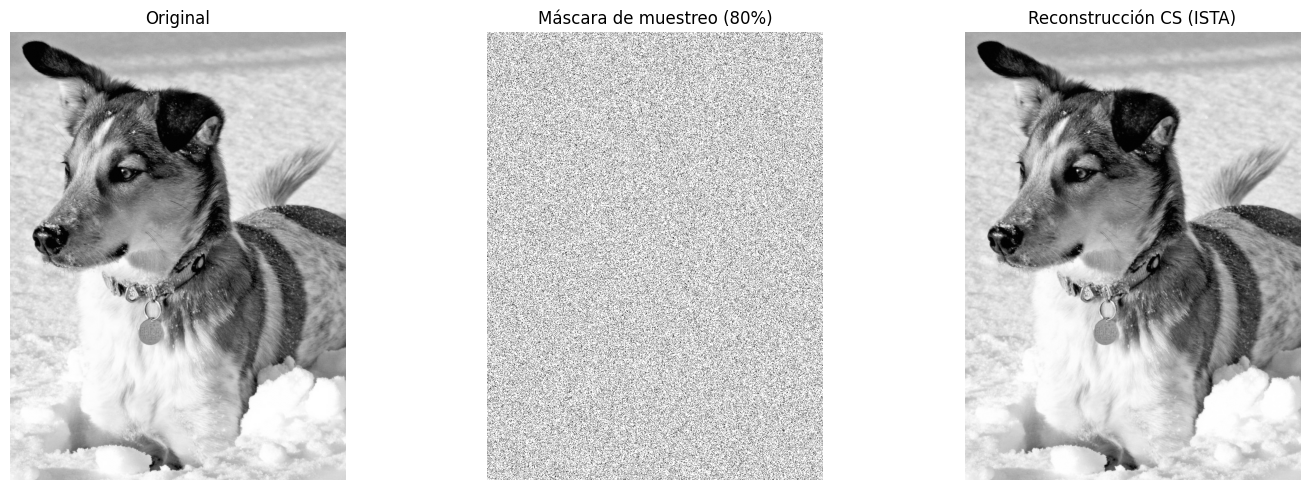

In [11]:
# Script principal
def main():
    # Parámetros
    sampling_fraction = 0.80
    n_iter = 300
    lam = 0.02
    alpha = 1.0

    # Cargar imagen
    img = load_image('/content/drive/MyDrive/dog.jpg')

    # Generar máscara y mediciones
    mask = create_mask(img.shape, sampling_fraction, seed=42)
    y = np.zeros_like(img)
    y[mask] = img[mask]

    # Reconstrucción CS vía ISTA
    recon = reconstruct_cs_ista(y, mask, n_iter=n_iter, lam=lam, alpha=alpha)

    # Visualizar resultados
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Máscara de muestreo (80%)')
    axes[1].axis('off')

    axes[2].imshow(recon, cmap='gray')
    axes[2].set_title('Reconstrucción CS (ISTA)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

## 3 Regresión y selección de modelo
### 1.


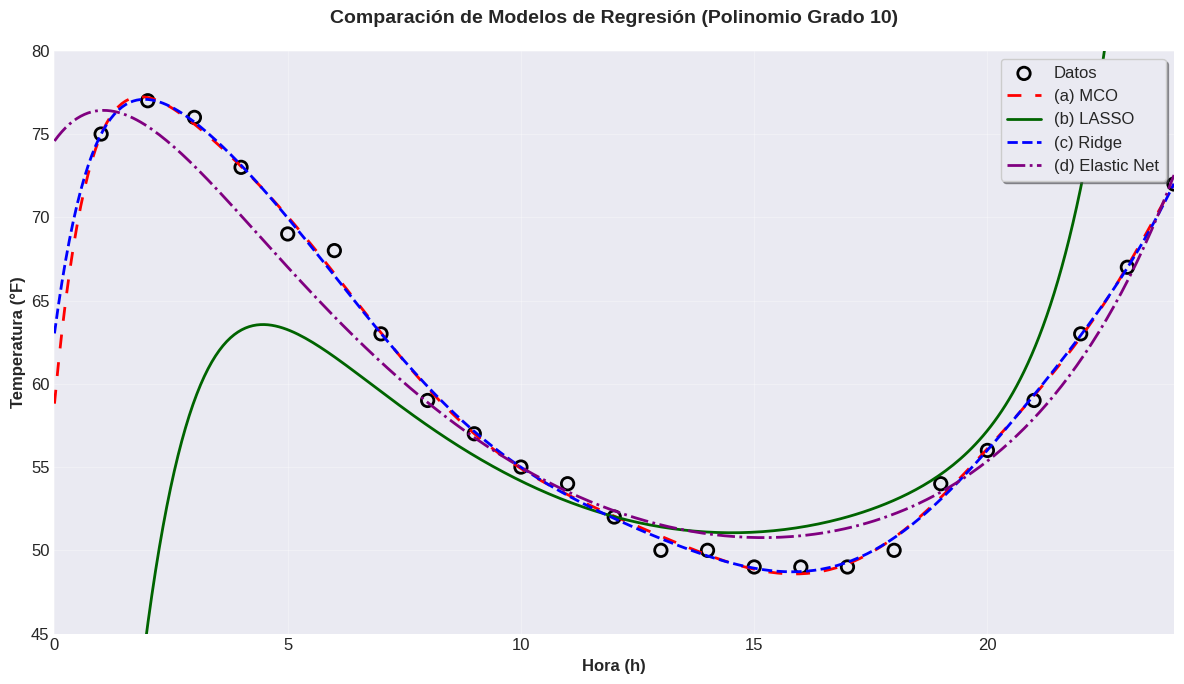

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.pipeline import make_pipeline

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 12, 'figure.figsize': (12, 7)})

# Datos
data = np.array([
    (1, 75), (2, 77), (3, 76), (4, 73), (5, 69), (6, 68),
    (7, 63), (8, 59), (9, 57), (10, 55), (11, 54), (12, 52),
    (13, 50), (14, 50), (15, 49), (16, 49), (17, 49), (18, 50),
    (19, 54), (20, 56), (21, 59), (22, 63), (23, 67), (24, 72)
])
t = data[:, 0].reshape(-1, 1)
y = data[:, 1]

# Escalado de características
scaler = StandardScaler().fit(t)
t_scaled = scaler.transform(t)

# Matriz de diseño (grado 10)
A = np.vander(t_scaled.flatten(), 11, increasing=True)

# (a) Mínimos cuadrados ordinarios
alpha_ls, *_ = np.linalg.lstsq(A, y, rcond=None)

# (b) LASSO con pipeline
lasso = make_pipeline(
    StandardScaler(with_mean=False),  # No centrar (ya tenemos intercepto)
    LassoCV(
        alphas=np.logspace(-6, 3, 300),
        fit_intercept=False,
        max_iter=100000,
        cv=5,
        tol=1e-2
    )
).fit(A, y)
alpha_lasso = lasso.named_steps['lassocv'].coef_

# (c) Ridge
ridge = RidgeCV(
    alphas=np.logspace(-3, 6, 300),
    fit_intercept=False,
    store_cv_results=True
).fit(A, y)
alpha_ridge = ridge.coef_

# (d) Elastic Net
enet = ElasticNetCV(
    alphas=np.logspace(-5, 3, 300),
    l1_ratio=[.1, .3, .5, .7, .9, .95, .99, 1],
    fit_intercept=False,
    max_iter=100000,
    cv=5,
    tol=1e-2
).fit(A, y)
alpha_enet = enet.coef_

# Generación de predicciones
t_fit = np.linspace(0, 24, 300).reshape(-1, 1)
t_fit_scaled = scaler.transform(t_fit)
A_pred = np.vander(t_fit_scaled.flatten(), 11, increasing=True)

y_ls = A_pred @ alpha_ls
y_lasso = A_pred @ alpha_lasso
y_ridge = A_pred @ alpha_ridge
y_enet = A_pred @ alpha_enet

# Visualización mejorada
fig, ax = plt.subplots()
ax.scatter(t, y, s=80, facecolors='none', edgecolors='black', linewidth=2, label='Datos')

styles = {
    '(a) MCO': ('y_ls', 'red', (0, (5, 5))),
    '(b) LASSO': ('y_lasso', 'darkgreen', '-'),
    '(c) Ridge': ('y_ridge', 'blue', '--'),
    '(d) Elastic Net': ('y_enet', 'purple', '-.')
}

for label, (var, color, ls) in styles.items():
    ax.plot(t_fit, eval(var), color=color, linestyle=ls, linewidth=2, label=label)

ax.set_xlabel('Hora (h)', fontweight='bold')
ax.set_ylabel('Temperatura (°F)', fontweight='bold')
ax.set_title('Comparación de Modelos de Regresión (Polinomio Grado 10)', pad=20, fontsize=14, fontweight='bold')
ax.set_xlim(0, 24)
ax.set_ylim(45, 80)

ax.legend(loc='upper right', frameon=True, shadow=True)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()